In [145]:
import yfinance as yf  
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import get_data as gd
from portfolio import *

In [153]:
spxs = yf.Ticker('SPXS')
spxl = yf.Ticker('SPXL')

spxs_close = amzn.history(start="2020-01-01")['Close']
spxl_close = aapl.history(start="2020-01-01")['Close']

spxs_returns = spxs.history(start="2020-01-01")['Close'].pct_change()[1:]
spxl_returns = spxl.history(start="2020-01-01")['Close'].pct_change()[1:]

closes = np.array([spxs_close.values, spxl_close.values])
returns = np.array([spxs_returns.values, spxl_returns.values])

pi = pd.DataFrame(closes.T)

In [692]:
closes.shape

(2, 645)

In [306]:
np.dot(port_w,returns).shape

(644,)

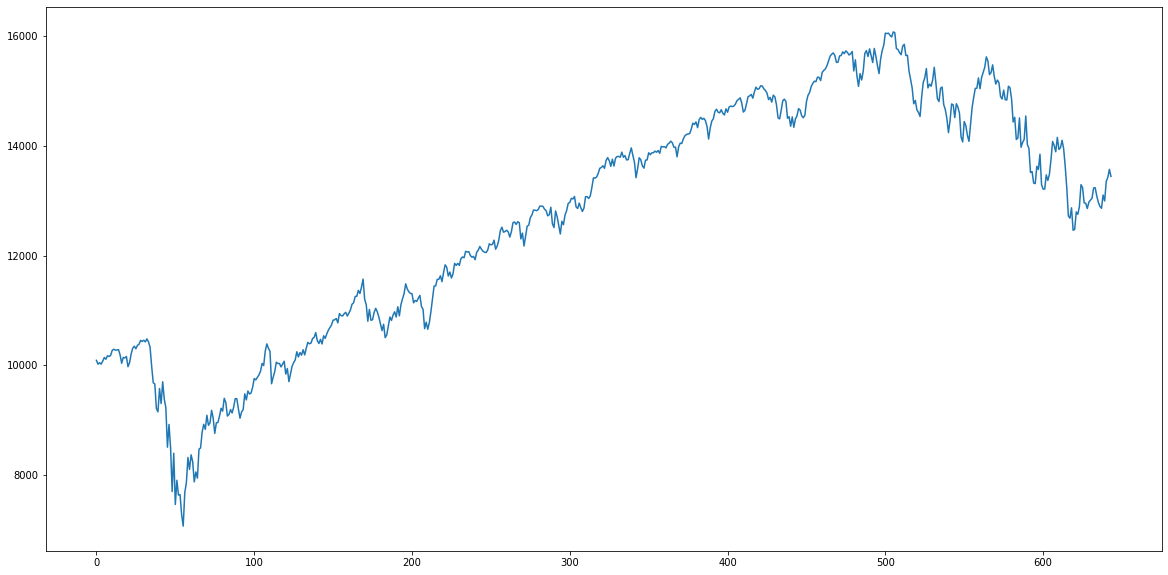

In [713]:
pval = 10000
spxs_w = -0.66
spxl_w = -0.33

port_w = np.array([spxs_w, spxl_w])

plt.plot(np.cumprod(np.dot(port_w,returns)+1)*pval)

In [479]:
# plt.rcParams["figure.figsize"] = (20,10)
# spxs_s = -(pval*spxs_w)/spxs_close.values[0]
# spxs_s = -(pval*spxl_w)/spxl_close.values[0]

# port_shares = np.array([spxs_s, spxs_s])

# plt.plot(np.cumprod(np.dot(port_w,returns)+1)*pval)
# plt.plot(np.dot(port_shares, closes))
# plt.legend(['Rebalanced','One Time Purchase'])

In [133]:
#portofolio value at time -1
onetime = np.dot(port_shares, closes)
onetime[-1]

4901.154806505099

In [476]:
def rebalance_criteria(closes, pval, port_w, threhold=0.20):
    
    nbr_rebalances = 0
    weights_t = np.zeros((pi.shape))
    shares_t = np.zeros((pi.shape))
    portolio_value_t = np.zeros((pi.shape[0]))
    portolio_value_t[0] = pval

    for i in range(pi.shape[0]):

        if i==0:

            weights_t[0,:] = port_w
            shares_t[0,:] = -(portolio_value_t[0]*port_w)/closes.T[0,:]

        else:
            temp_share_t = shares_t[i-1,:]
            temp_portofolio_t = portolio_value_t[i-1]
#             temp_weight_t = -(closes.T[i,:]*temp_share_t)/temp_portofolio_t
            temp_weight_t = -(closes.T[i,:]*temp_share_t)/(closes.T[i,:]@temp_share_t)
            
            #Rebalance
            if np.abs(temp_weight_t[0] - weights_t[0,0])/np.abs(weights_t[0,0])>threhold:
                weights_t[i,:] = port_w
                portolio_value_t[i] = closes.T[i,:]@temp_share_t
                shares_t[i,:] = -(portolio_value_t[i]*port_w)/closes.T[i,:]
                nbr_rebalances+=1
                
            #No Rebalance
            else:
                shares_t[i,:] = temp_share_t
                portolio_value_t[i] = closes.T[i,:]@temp_share_t
                weights_t[i,:] = -(closes.T[i,:]*temp_share_t)/portolio_value_t[i]
                
    return weights_t, shares_t, portolio_value_t,nbr_rebalances

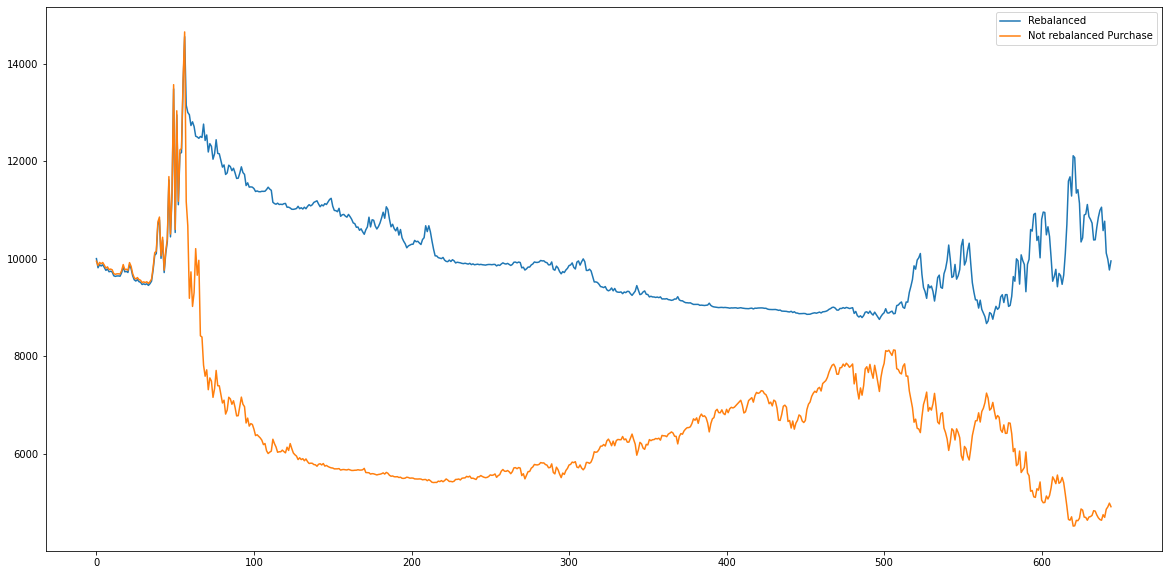

In [708]:
weights_t, shares_t, portolio_value_t, nbr_rebalances = rebalance_criteria(closes,pval,port_w, threhold=0.42)
plt.plot(portolio_value_t)
plt.plot(np.dot(port_shares, closes))
plt.legend(['Rebalanced','Not rebalanced Purchase'])

In [ ]:
# def calculate_stats(returns, weights_t, rf=0):
    
#     cov = np.cov(returns)
    
#     rp = weights_t[1:,:]@returns.T.mean(0)*252
#     rets = weights_t[1:,:]@returns
    
#     port_var = np.diag(weights_t[1:,:]@(cov*252)@weights_t[1:,:].T)
    
#     sharpe = (rp-rf)/np.sqrt(port_var)
    
#     return sharpe,rp,port_var,rets

# cov = np.cov(returns)
# rf = 0
# sharpe_ratios = []
# # weights_t = np.array(list([port_w])*645)
# for i in range(returns.T.shape[0]):
#     return_temp = returns.T[i,:]
#     rp = return_temp@weights_t[i+1,:]*252
#     rets = (return_temp)@weights_t[i+1,:]
#     port_var = weights_t[i+1,:]@cov*252@weights_t[i+1,:]
#     sharpe = (rp-rf)/np.sqrt(port_var)
#     sharpe_ratios.append(sharpe)

In [637]:
def get_stats(closes, weights):
    sharpe_ratios = []
    volatilities = []
    for i in range(weights.shape[0]):
        sharpe,rp,port_var,rets = getSharpe(pd.DataFrame(closes.T), weights[i,:])
        sharpe_ratios.append(sharpe)
        volatilities.append(port_var)
    return sharpe_ratios, volatilities


sharpe_ratios, volatilities = get_stats(closes, weights_t)

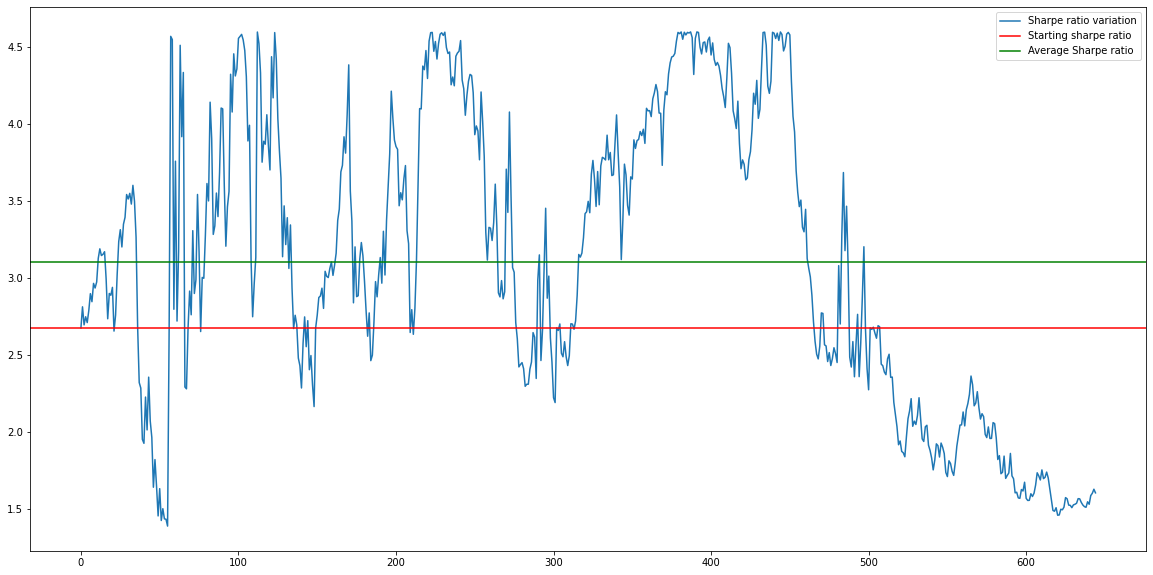

In [709]:
plt.plot(sharpe_ratios)
plt.axhline(y=sharpe_ratios[0], color='r', linestyle='-')
plt.axhline(y=np.mean(sharpe_ratios), color='g', linestyle='-')
plt.legend(['Sharpe ratio variation','Starting sharpe ratio', 'Average Sharpe ratio'])

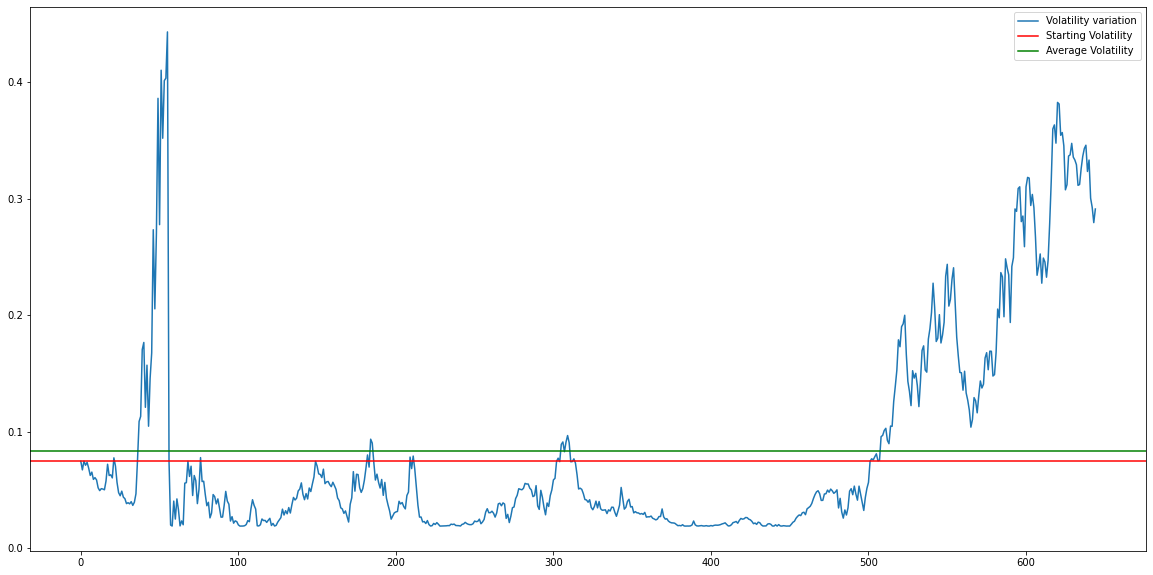

In [710]:
plt.plot(volatilities)
plt.axhline(y=volatilities[0], color='r', linestyle='-')
plt.axhline(y=np.mean(volatilities), color='g', linestyle='-')
plt.legend(['Volatility variation','Starting Volatility', 'Average Volatility'])

In [687]:
def find_info_threholds(closes, pval, port_w, threholds=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    all_results = dict()
    for threhold in threholds:
        weights_t, shares_t, portolio_value_t, nbr_rebalances = rebalance_criteria(closes, pval, port_w, threhold=threhold)
        sharpe_ratios, volatilities = get_stats(closes, weights_t)
        dict_resutls = {"weights":weights_t,"shares":shares_t,
                        "portolio_value":portolio_value_t,"nbr_rebalances":nbr_rebalances,
                        "sharpe_ratios":sharpe_ratios,"volatilities":volatilities,
                        "mean_sharpe_ratio":np.mean(sharpe_ratios),
                        "max_sharpe_ratio":np.max(sharpe_ratios),
                        "min_sharpe_ratio":np.min(sharpe_ratios),
                        "mean_volatility":np.mean(volatilities),
                        "max_volatility":np.max(volatilities),
                        "min_volatility":np.min(volatilities)}
                        
        all_results[threhold] = dict_resutls
    return all_results

def plot_threhold_balanced_not_rebalanced(closes, results, threhold):
    portolio_value_t = results[threhold]['portolio_value']
    port_shares = results[threhold]['shares']
    plt.plot(portolio_value_t)
    plt.plot(np.dot(port_shares[0], closes))
    plt.legend(['Rebalanced','Not rebalanced Purchase'])
    

def plot_sharpe_ratio_per_threhold(results, threhold):
    sharpe_ratios = results[threhold]['sharpe_ratios']
    plt.plot(sharpe_ratios)
    plt.axhline(y=sharpe_ratios[0], color='r', linestyle='-')
    plt.axhline(y=np.mean(sharpe_ratios), color='g', linestyle='-')
    plt.legend(['Sharpe ratio variation','Not rebalanced sharpe ratio', 'Average Sharpe ratio'])
    
def plot_volatility_per_threhold(results, threhold):
    volatilities = results[threhold]['volatilities']
    plt.plot(volatilities)
    plt.axhline(y=volatilities[0], color='r', linestyle='-')
    plt.axhline(y=np.mean(volatilities), color='g', linestyle='-')
    plt.legend(['Volatility variation','Not rebalanced Volatility', 'Average Volatility'])

In [699]:
results = find_info_threholds(closes, pval, port_w, threholds=[0,0.1,0.2,0.3,0.42,0.5,0.6,0.7,0.8,0.9,1])

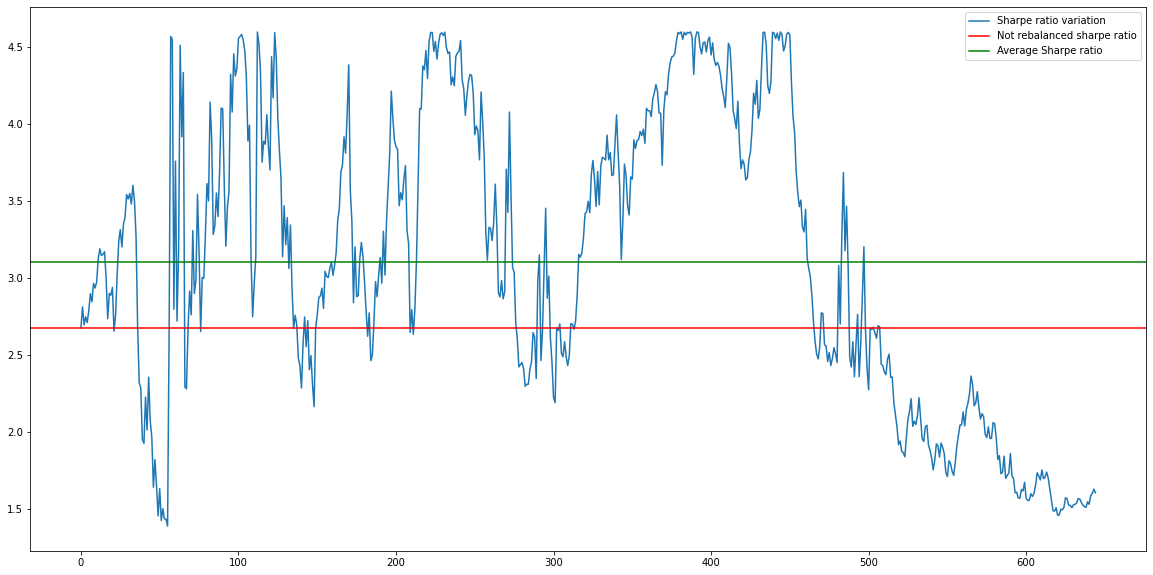

In [700]:
plt.plot(sharpe_ratios)
plt.axhline(y=sharpe_ratios[0], color='r', linestyle='-')
plt.axhline(y=np.mean(sharpe_ratios), color='g', linestyle='-')
plt.legend(['Sharpe ratio variation','Not rebalanced sharpe ratio', 'Average Sharpe ratio'])

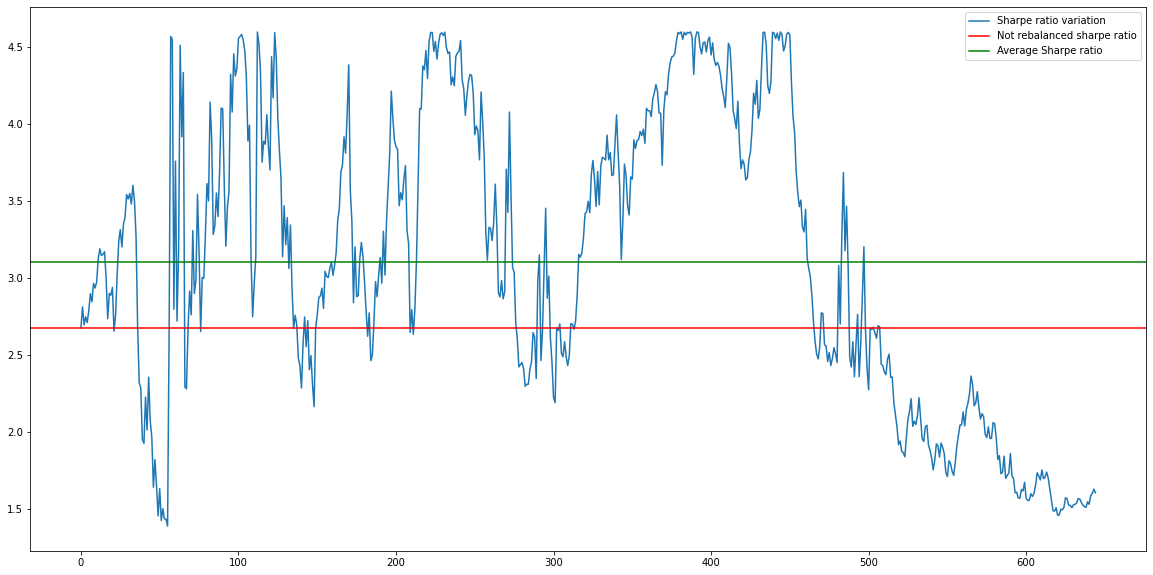

In [701]:
plot_sharpe_ratio_per_threhold(results ,0.42)

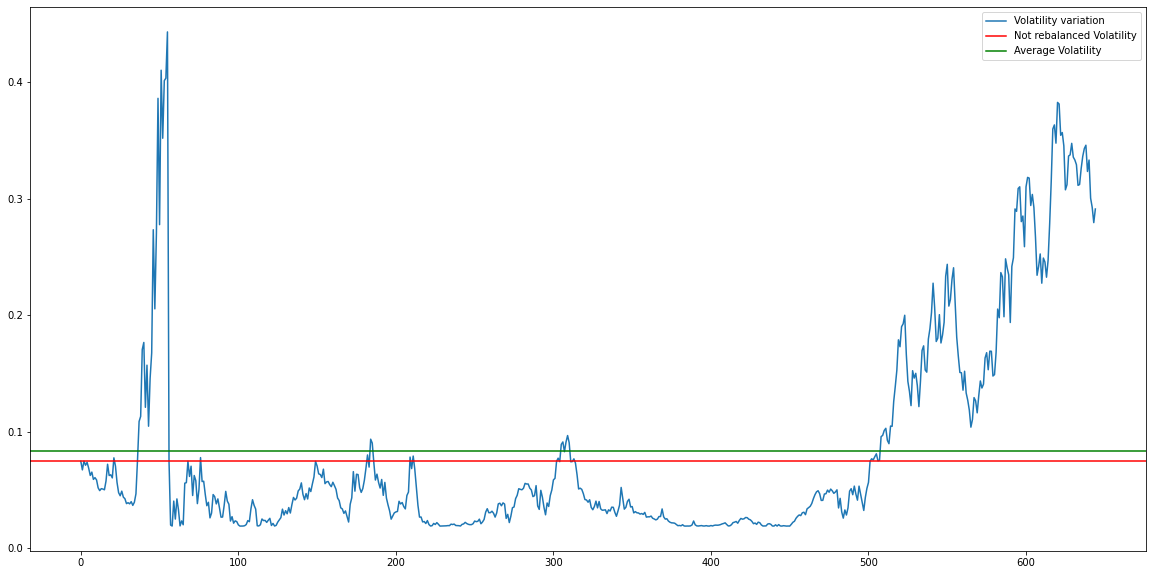

In [702]:
plot_volatility_per_threhold(results, 0.42)

In [703]:
means_sharpe_ratios = [results[key]['mean_sharpe_ratio'] for key in results.keys()]
means_volatilities = [results[key]['mean_volatility'] for key in results.keys()]

In [704]:
means_sharpe_ratios

[2.6781484650457217,
 2.905439910518116,
 3.0151624044569347,
 3.2720625683871916,
 3.1085880813407902,
 2.8320507889734183,
 3.202436143716745,
 2.9042309434403286,
 2.1827854444537436,
 1.6864511153803374,
 1.6864511153803374]

In [705]:
means_volatilities

[0.07455423920834384,
 0.06629841867402139,
 0.07022548726382208,
 0.06658607475609192,
 0.08309082068360125,
 0.10001216978838111,
 0.0653748837113906,
 0.08832912278552943,
 0.14924930980061452,
 0.20512384325841695,
 0.20512384325841695]

In [134]:
#portofolio value at time -1 verification
new_pval = (closes[0][-1]*spxs_s + closes[1][-1]*spxs_s)
new_pval

4901.154806505099

In [244]:
#weights at time -1
closes[0][-1]*amzn_s/new_pval, closes[1][-1]*aapl_s/new_pval
# (closes[:,-1]*port_shares)/new_pval

(0.233821803249008, 0.7661781967509921)